In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [3]:
df=pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


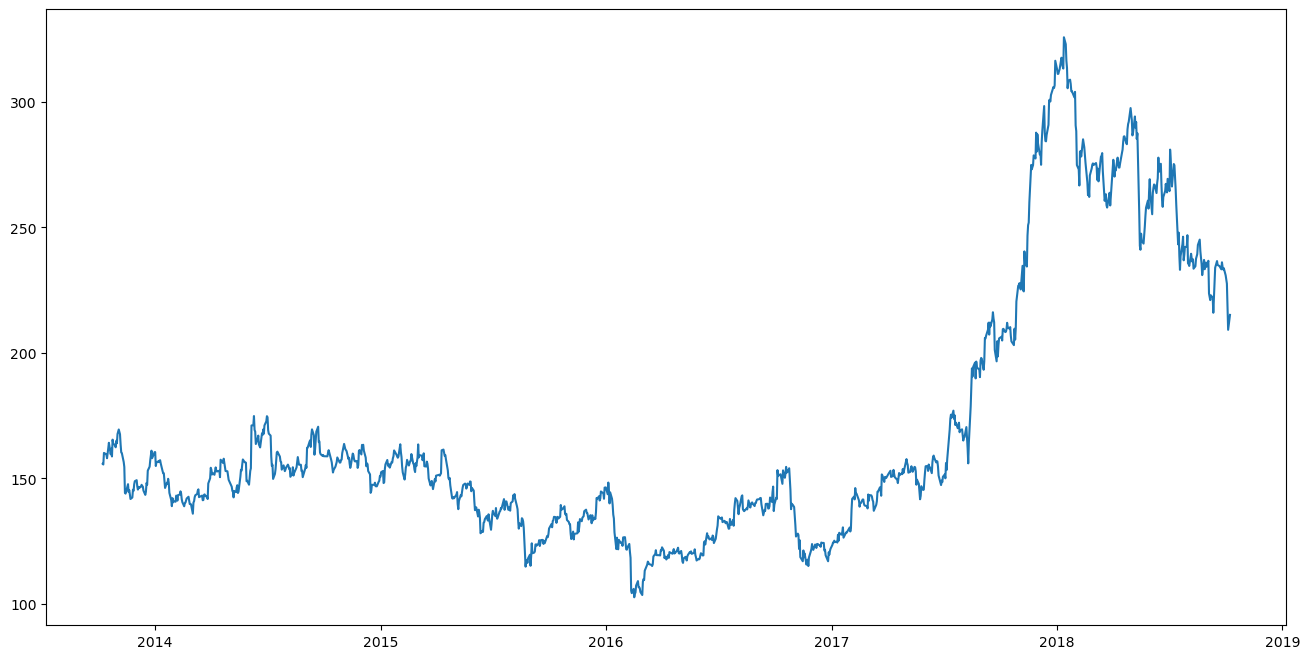

In [4]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [5]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [8]:
if 'Date' in new_dataset.columns:
    new_dataset.drop('Date', axis=1, inplace=True)


# Convert the DataFrame to numpy values after dropping non-numeric columns
final_dataset = new_dataset.values

# Now, you can apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

# Split the dataset into train and validation sets
train_data = scaled_data[0:987, :]
valid_data = scaled_data[987:, :]

# Prepare your training data
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(train_data[i-60:i, 0])
    y_train_data.append(train_data[i, 0])
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape x_train_data as needed for your model
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [9]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

/Users/rakeshnagaragattajayanna/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


927/927 - 13s - 14ms/step - loss: 0.0012


In [10]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [11]:
lstm_model.save("saved_model.h5")

/var/folders/hy/wj5bj9v168qcdx80gyjdj40h0000gn/T/ipykernel_85648/2013958942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


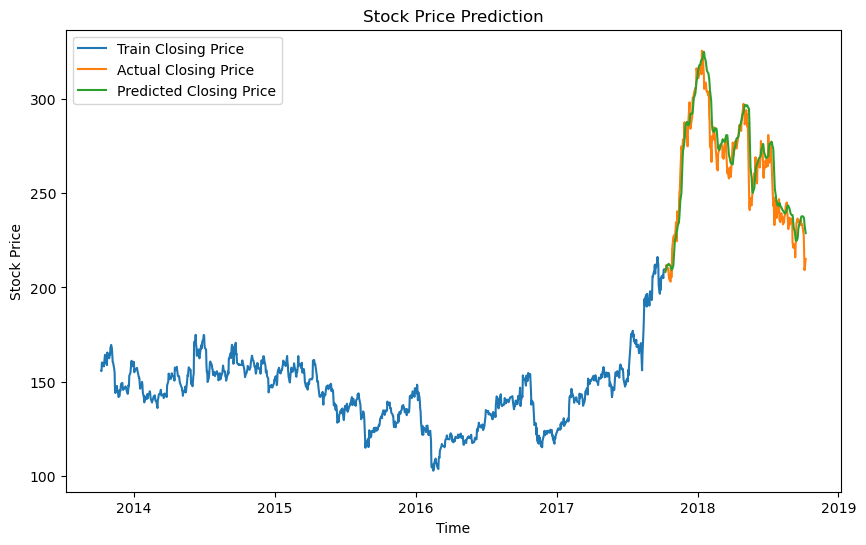

In [13]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions'] = predicted_closing_price

plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size

# Plotting the actual closing prices from the training data
plt.plot(train_data["Close"], label='Train Closing Price')

# Plotting both actual and predicted closing prices from the validation data
plt.plot(valid_data["Close"], label='Actual Closing Price')
plt.plot(valid_data["Predictions"], label='Predicted Closing Price')

plt.legend(loc='best')  # Adds a legend with the best location determined automatically
plt.title('Stock Price Prediction')  # Optional: Adds a title to your plot
plt.xlabel('Time')  # Optional: Adds a label to the x-axis
plt.ylabel('Stock Price')  # Optional: Adds a label to the y-axis
plt.show()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
actual = valid_data['Close'].values  # Actual closing prices
predictions = valid_data['Predictions'].values  # Predictions made by the LSTM model

# Calculate evaluation metrics
mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predictions)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 7.389431085894184
Mean Squared Error (MSE): 107.20891898500697
Root Mean Squared Error (RMSE): 10.35417398854235
R-squared (R²): 0.8680253646894561


# Trying to Optimise a model

In [23]:
#from keras.models import Sequential
#from keras.layers import LSTM, Dense, Dropout, Bidirectional
#from keras.optimizers import Adam
#input_shape=(x_train_data.shape[1], x_train_data.shape[2])

#model = Sequential()
#model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data[1], 1)))
#model.add(Dropout(0.2))  # Regularization with Dropout
#model.add(Bidirectional(LSTM(units=50, return_sequences=False)))  # Bidirectional LSTM layer
#model.add(Dropout(0.2))  # Regularization with Dropout
#model.add(Dense(units=1))  # Output layer

# Compile the model
#optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
#model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
#model.fit(x_train_data, y_train_data, epochs=100, batch_size=32)  # Adjust epochs and batch size as needed
